# Trix
### buy--condition : TRIX_Hist > 0 and StochRSI < 0.8
### sell--condition : TRIX_Hist < 0 and StochRSI > 0.2

In [9]:
# -- Import --
import pandas as pd
from binance.client import Client
import ta
import matplotlib.pyplot as plt
import numpy as np
# -- Import --
import pandas as pd
from binance.client import Client
import ta
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time
from math import *
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# -- Define Binance Client --
client = Client()

# -- You can change the crypto pair ,the start date and the time interval below --
pairName = "BTCUSDT"
startDate = "01 january 2017"
timeInterval = Client.KLINE_INTERVAL_1HOUR

# -- Load all price data from binance API --
klinesT = client.get_historical_klines(pairName, timeInterval, startDate)

# -- Define your dataset --
df = pd.DataFrame(klinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
df['close'] = pd.to_numeric(df['close'])
df['high'] = pd.to_numeric(df['high'])
df['low'] = pd.to_numeric(df['low'])
df['open'] = pd.to_numeric(df['open'])

# -- Set the date to index --
df = df.set_index(df['timestamp'])
df.index = pd.to_datetime(df.index, unit='ms')
del df['timestamp']

print("Data loaded 100%")

# -- Uncomment the line below if you want to check your price dataset --
# d

Data loaded 100%


In [17]:
# -- Drop all columns we do not need --
df.drop(df.columns.difference(['open','high','low','close','volume']), 1, inplace=True)

# -- Indicators, you can edit every value --
df['EMA200'] = ta.trend.ema_indicator(close=df['close'], window=200)
# -- Trix Indicator --
trixLength = 7
trixSignal = 15
df['TRIX'] = ta.trend.ema_indicator(ta.trend.ema_indicator(ta.trend.ema_indicator(close=df['close'], window=trixLength), window=trixLength), window=trixLength)
df['TRIX_PCT'] = df["TRIX"].pct_change()*100
df['TRIX_SIGNAL'] = ta.trend.sma_indicator(df['TRIX_PCT'],trixSignal)
df['TRIX_HISTO'] = df['TRIX_PCT'] - df['TRIX_SIGNAL']


# -- Stochasitc RSI --
df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=12, smooth1=3, smooth2=3)
stochTop = 0.7
stochBottom = 0.28

print("Indicators loaded 100%")

# -- Uncomment the line below if you want to check your dataset with indicators --

Indicators loaded 100%


Loading... 23 / 23


<ipython-input-18-2c67453e401c>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfTest['STOCH_RSI'] = ta.momentum.stochrsi(close=dfTest['close'], window=i, smooth1=3, smooth2=3)


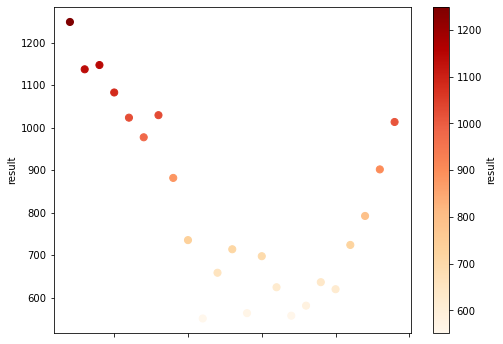

    param1       result
9     16.0   551.199378
15    22.0   557.732446
12    19.0   563.803609
16    23.0   581.368827
18    25.0   620.079810
14    21.0   624.697339
17    24.0   636.645556
10    17.0   658.798103
13    20.0   697.756922
11    18.0   714.087816
19    26.0   724.209067
8     15.0   735.614402
20    27.0   792.404403
7     14.0   881.907687
21    28.0   901.971062
5     12.0   977.546156
22    29.0  1013.526377
4     11.0  1023.687984
6     13.0  1029.597582
3     10.0  1082.965589
1      8.0  1137.507546
2      9.0  1147.559248
0      7.0  1248.872869


In [18]:
dfTest = None
dt = None
dt = pd.DataFrame(columns = ['param1', 'result'])

# dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
dfTest = df['2021-01-01':]

# -- Condition to BUY market --
def buyCondition(row):
  if row['TRIX_HISTO'] > 0 and row['STOCH_RSI'] < stochTop:
    return True
  else:
    return False

# -- Condition to SELL market --  
def sellCondition(row):
  if row['TRIX_HISTO'] < 0 and row['STOCH_RSI'] > stochBottom:
    return True
  else:
    return False

loopI = [7,30,1]
enumI = ceil((loopI[1] - loopI[0]) / loopI[2])

count = 0
maxCount = enumI
for i in range(loopI[0], loopI[1], loopI[2]):
  clear_output(wait=True)
  count += 1
  print("Loading...",count,'/',maxCount)
  # -- You can change variables below --
  usdt = 1000
  coin = 0

  dfTest['STOCH_RSI'] = ta.momentum.stochrsi(close=dfTest['close'], window=i, smooth1=3, smooth2=3)

  for index, row in dfTest.iterrows():
    #BUY
    if buyCondition(row) and usdt > 0:
      coin = (usdt/dfTest['close'][index]) - 0.0007*(usdt/dfTest['close'][index])
      usdt = 0

    #SELL
    elif sellCondition(row) and coin > 0:
      usdt = coin*dfTest['close'][index] - (0.0007*coin*dfTest['close'][index])
      coin = 0

  myrow = {'param1': i,'result': coin*dfTest.iloc[len(dfTest)-1]['close'] + usdt}
  dt = dt.append(myrow,ignore_index=True)   

dt.plot.scatter(x='param1',y=1,c='result',s=50,colormap='OrRd',figsize=(8,6))
plt.show()

print(dt.sort_values(by=['result']))

Loading... 40 / 40


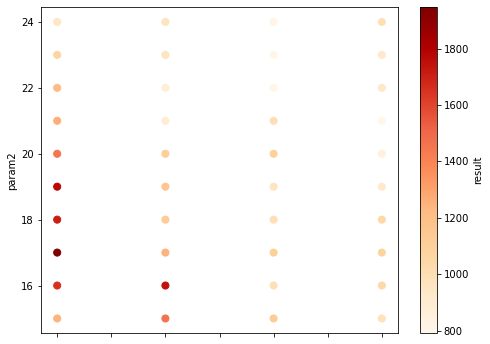

    param1  param2       result
36    10.0    21.0   791.101654
28     9.0    23.0   801.047237
27     9.0    22.0   801.990872
29     9.0    24.0   815.232015
35    10.0    20.0   850.440505
17     8.0    22.0   877.944047
16     8.0    21.0   892.509014
38    10.0    23.0   924.551051
34    10.0    19.0   925.946847
37    10.0    22.0   938.914567
9      7.0    24.0   947.791862
19     8.0    24.0   964.258550
24     9.0    19.0   964.545670
18     8.0    23.0   971.351854
30    10.0    15.0   984.580393
23     9.0    18.0   990.762170
39    10.0    24.0   994.714457
21     9.0    16.0   995.036343
26     9.0    21.0   999.412535
31    10.0    16.0  1042.436250
33    10.0    18.0  1047.557923
8      7.0    23.0  1071.534456
32    10.0    17.0  1075.812227
25     9.0    20.0  1098.408264
22     9.0    17.0  1102.660536
15     8.0    20.0  1115.323931
20     9.0    15.0  1128.784839
13     8.0    18.0  1130.961252
14     8.0    19.0  1158.956993
7      7.0    22.0  1221.415119
0      7

In [19]:
dfTest = None
dt = None
dt = pd.DataFrame(columns = ['param1','param2', 'result'])

# dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
dfTest = df['2021-01-01':]


# -- Condition to BUY market --
def buyCondition(row):
  if row['TRIX_HISTO'] > 0 and row['STOCH_RSI'] < stochTop:
    return True
  else:
    return False

# -- Condition to SELL market --  
def sellCondition(row):
  if row['TRIX_HISTO'] < 0 and row['STOCH_RSI'] > stochBottom:
    return True
  else:
    return False

loopI = [7,11,1]
enumI = ceil((loopI[1] - loopI[0]) / loopI[2])

loopJ = [15,25,1]
enumJ = ceil((loopJ[1] - loopJ[0]) / loopJ[2])

count = 0
maxCount = enumI * enumJ
for i in range(loopI[0], loopI[1], loopI[2]):
  for j in range(loopJ[0], loopJ[1], loopJ[2]):
    clear_output(wait=True)
    count += 1
    print("Loading...",count,'/',maxCount)
    # -- You can change variables below --
    usdt = 1000
    coin = 0

    trixLength = i
    trixSignal = j
    dfTest['TRIX'] = ta.trend.ema_indicator(ta.trend.ema_indicator(ta.trend.ema_indicator(close=dfTest['close'], window=trixLength), window=trixLength), window=trixLength)
    dfTest['TRIX_PCT'] = dfTest["TRIX"].pct_change()*100
    dfTest['TRIX_SIGNAL'] = ta.trend.sma_indicator(dfTest['TRIX_PCT'],trixSignal)
    dfTest['TRIX_HISTO'] = dfTest['TRIX_PCT'] - dfTest['TRIX_SIGNAL']

    for index, row in dfTest.iterrows():
      #BUY
      if buyCondition(row) and usdt > 0:
        coin = (usdt/dfTest['close'][index]) - 0.0007*(usdt/dfTest['close'][index])
        usdt = 0

      #SELL
      elif sellCondition(row) and coin > 0:
        usdt = coin*dfTest['close'][index] - (0.0007*coin*dfTest['close'][index])
        coin = 0

    myrow = {'param1': i, 'param2': j,'result': coin*dfTest.iloc[len(dfTest)-1]['close'] + usdt}
    dt = dt.append(myrow,ignore_index=True)   

dt.plot.scatter(x='param1',y='param2',c='result',s=50,colormap='OrRd',figsize=(8,6))
plt.show()

print(dt.sort_values(by=['result']))

Loading... 196 / 196


<ipython-input-21-d74633a667e6>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfTest['STOCH_RSI'] = ta.momentum.stochrsi(close=dfTest['close'], window=k, smooth1=3, smooth2=3)


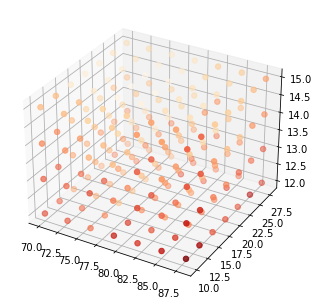

     param1  param2  param3       result
71     76.0    19.0    15.0   536.683193
75     76.0    22.0    15.0   554.022664
99     79.0    19.0    15.0   556.523000
67     76.0    16.0    15.0   559.492818
103    79.0    22.0    15.0   574.503468
..      ...     ...     ...          ...
84     79.0    10.0    12.0  1291.736598
140    85.0    10.0    12.0  1313.010359
188    88.0    25.0    12.0  1340.272703
172    88.0    13.0    12.0  1381.688887
168    88.0    10.0    12.0  1466.554057

[196 rows x 4 columns]


In [21]:
dfTest = None
dt = None
dt = pd.DataFrame(columns = ['param1','param2', 'param3', 'result'])

# dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
dfTest = df['2021-01-01':]


# -- Condition to BUY market --
def buyCondition(row, param):
  if row['TRIX_HISTO'] > 0 and row['STOCH_RSI'] < param:
    return True
  else:
    return False

# -- Condition to SELL market --  
def sellCondition(row, param):
  if row['TRIX_HISTO'] < 0 and row['STOCH_RSI'] > param:
    return True
  else:
    return False

loopI = [70,90,3]
enumI = ceil((loopI[1] - loopI[0]) / loopI[2])

loopJ = [10,30,3]
enumJ = ceil((loopJ[1] - loopJ[0]) / loopJ[2])

loopK = [12,16,1]
enumK = ceil((loopK[1] - loopK[0]) / loopK[2])

count = 0
maxCount = enumI * enumJ * enumK
for i in range(loopI[0], loopI[1], loopI[2]):
  for j in range(loopJ[0], loopJ[1], loopJ[2]):
    for k in range(loopK[0], loopK[1], loopK[2]):
      clear_output(wait=True)
      count += 1
      print("Loading...",count,'/',maxCount)
      # -- You can change variables below --
      usdt = 1000
      coin = 0

      trixLength = i
      trixSignal = j
      dfTest['STOCH_RSI'] = ta.momentum.stochrsi(close=dfTest['close'], window=k, smooth1=3, smooth2=3)

      for index, row in dfTest.iterrows():
        #BUY
        if buyCondition(row, i/100) and usdt > 0:
          coin = (usdt/dfTest['close'][index]) - 0.0007*(usdt/dfTest['close'][index])
          usdt = 0

        #SELL
        elif sellCondition(row, j/100) and coin > 0:
          usdt = coin*dfTest['close'][index] - (0.0007*coin*dfTest['close'][index])
          coin = 0

      myrow = {'param1': i, 'param2': j, 'param3': k,'result': coin*dfTest.iloc[len(dfTest)-1]['close'] + usdt}
      dt = dt.append(myrow,ignore_index=True)   

# dt.plot.scatter(x='param1',y='param2',c='result',s=50,colormap='rainbow',figsize=(8,6))
# plt.show()

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(dt['param1'], dt['param2'], dt['param3'],c=dt['result'],cmap='OrRd', s=30)
plt.show()

print(dt.sort_values(by=['result']))

In [11]:
dfTest = df.copy()

# -- If you want to run your BackTest on a specific period, uncomment the line below --
# dfTest = df['2021-09-01':]

# -- Definition of dt, that will be the dataset to do your trades analyses --
dt = None
dt = pd.DataFrame(columns = ['date','position', 'reason', 'price', 'frais' ,'fiat', 'coins', 'wallet', 'drawBack'])

# -- You can change variables below --
usdt = 100
makerFee = 0.0002
takerFee = 0.0007

# -- Do not touch these values --
initalWallet = usdt
wallet = usdt
coin = 0
lastAth = 0
previousRow = dfTest.iloc[0]
stopLoss = 0
takeProfit = 500000
buyReady = True
sellReady = True

# -- Condition to BUY market --
def buyCondition(row, previousRow):
  if row['TRIX_HISTO'] > 0 and row['STOCH_RSI'] < 0.8:
    return True
  else:
    return False

# -- Condition to SELL market --  
def sellCondition(row, previousRow):
  if row['TRIX_HISTO'] < 0 and row['STOCH_RSI'] > 0.2:
    return True
  else:
    return False

# -- Iteration on all your price dataset (df) --
for index, row in dfTest.iterrows():
  # -- Buy market order --
  if buyCondition(row, previousRow) and usdt > 0 and buyReady == True:
    # -- You can define here at what price you buy --
    buyPrice = row['close']

    # -- Define the price of you SL and TP or comment it if you don't want a SL or TP --
    # stopLoss = buyPrice - 0.02 * buyPrice
    # takeProfit = buyPrice + 0.04 * buyPrice

    coin = usdt / buyPrice
    fee = takerFee * coin
    coin = coin - fee
    usdt = 0
    wallet = coin * row['close']

    # -- Check if your wallet hit a new ATH to know the drawBack --
    if wallet > lastAth:
      lastAth = wallet

    # -- You can uncomment the line below if you want to see logs --
    # print("Buy COIN at",buyPrice,'$ the', index)

    # -- Add the trade to DT to analyse it later --
    myrow = {'date': index, 'position': "Buy", 'reason':'Buy Market Order','price': buyPrice,'frais': fee * row['close'],'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)
  
  # -- Stop Loss --
  elif row['low'] < stopLoss and coin > 0:
    sellPrice = stopLoss
    usdt = coin * sellPrice
    fee = makerFee * usdt
    usdt = usdt - fee
    coin = 0
    buyReady = False
    wallet = usdt

    # -- Check if your wallet hit a new ATH to know the drawBack --
    if wallet > lastAth:
      lastAth = wallet
      
    # -- You can uncomment the line below if you want to see logs --
    # print("Sell COIN at Stop Loss",sellPrice,'$ the', index)

    # -- Add the trade to DT to analyse it later --
    myrow = {'date': index,'position': "Sell", 'reason':'Sell Stop Loss','price': sellPrice,'frais': fee,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)    

  # -- Sell Market Order --
  elif sellCondition(row, previousRow) and coin > 0 and sellReady == True:

    # -- You can define here at what price you buy --
    sellPrice = row['close']
    usdt = coin * sellPrice
    fee = takerFee * usdt
    usdt = usdt - fee
    coin = 0
    buyReady = True
    wallet = usdt

    # -- Check if your wallet hit a new ATH to know the drawBack --
    if wallet > lastAth:
      lastAth = wallet

    # -- You can uncomment the line below if you want to see logs --  
    # print("Sell COIN at",sellPrice,'$ the', index)

    # -- Add the trade to DT to analyse it later --
    myrow = {'date': index,'position': "Sell", 'reason':'Sell Market Order','price': sellPrice,'frais': fee,'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)
  
  previousRow = row

# -- BackTest Analyses --
dt = dt.set_index(dt['date'])
dt.index = pd.to_datetime(dt.index)
dt['resultat'] = dt['wallet'].diff()
dt['resultat%'] = dt['wallet'].pct_change()*100
dt.loc[dt['position']=='Buy','resultat'] = None
dt.loc[dt['position']=='Buy','resultat%'] = None

dt['tradeIs'] = ''
dt.loc[dt['resultat']>0,'tradeIs'] = 'Good'
dt.loc[dt['resultat']<=0,'tradeIs'] = 'Bad'

iniClose = dfTest.iloc[0]['close']
lastClose = dfTest.iloc[len(dfTest)-1]['close']
holdPercentage = ((lastClose - iniClose)/iniClose) * 100
algoPercentage = ((wallet - initalWallet)/initalWallet) * 100
vsHoldPercentage = ((algoPercentage - holdPercentage)/holdPercentage) * 100

try:
    tradesPerformance = round(dt.loc[(dt['tradeIs'] == 'Good') | (dt['tradeIs'] == 'Bad'), 'resultat%'].sum()
            / dt.loc[(dt['tradeIs'] == 'Good') | (dt['tradeIs'] == 'Bad'), 'resultat%'].count(), 2)
except:
    tradesPerformance = 0
    print("/!\ There is no Good or Bad Trades in your BackTest, maybe a problem...")

try:
    totalGoodTrades = dt.groupby('tradeIs')['date'].nunique()['Good']
    AveragePercentagePositivTrades = round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].sum()
                                           / dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].count(), 2)
    idbest = dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].idxmax()
    bestTrade = str(
        round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].max(), 2))
except:
    totalGoodTrades = 0
    AveragePercentagePositivTrades = 0
    idbest = ''
    bestTrade = 0
    print("/!\ There is no Good Trades in your BackTest, maybe a problem...")

try:
    totalBadTrades = dt.groupby('tradeIs')['date'].nunique()['Bad']
    AveragePercentageNegativTrades = round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].sum()
                                           / dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].count(), 2)
    idworst = dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].idxmin()
    worstTrade = round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].min(), 2)
except:
    totalBadTrades = 0
    AveragePercentageNegativTrades = 0
    idworst = ''
    worstTrade = 0
    print("/!\ There is no Bad Trades in your BackTest, maybe a problem...")

totalTrades = totalBadTrades + totalGoodTrades
winRateRatio = (totalGoodTrades/totalTrades) * 100

reasons = dt['reason'].unique()

In [12]:
print("Pair Symbol :",pairName)
print("Period : [" + str(dfTest.index[0]) + "] -> [" +
      str(dfTest.index[len(dfTest)-1]) + "]")
print("Starting balance :", initalWallet, "$")

print("\n----- General Informations -----")
print("Final balance :", round(wallet, 2), "$")
print("Performance vs US Dollar :", round(algoPercentage, 2), "%")
print("Buy and Hold Performence :", round(holdPercentage, 2), "%")
print("Performance vs Buy and Hold :", round(vsHoldPercentage, 2), "%")
print("Best trade : +"+bestTrade, "%, the", idbest)
print("Worst trade :", worstTrade, "%, the", idworst)
print("Worst drawBack :", str(100*round(dt['drawBack'].min(), 2)), "%")
print("Total fees : ", round(dt['frais'].sum(), 2), "$")

print("\n----- Trades Informations -----")
print("Total trades on period :",totalTrades)
print("Number of positive trades :", totalGoodTrades)
print("Number of negative trades : ", totalBadTrades)
print("Trades win rate ratio :", round(winRateRatio, 2), '%')
print("Average trades performance :",tradesPerformance,"%")
print("Average positive trades :", AveragePercentagePositivTrades, "%")
print("Average negative trades :", AveragePercentageNegativTrades, "%")

print("\n----- Trades Reasons -----")
reasons = dt['reason'].unique()
for r in reasons:
    print(r+" number :", dt.groupby('reason')['date'].nunique()[r])

Pair Symbol : BTCUSDT
Period : [2017-08-17 04:00:00] -> [2022-02-19 13:00:00]
Starting balance : 100 $

----- General Informations -----
Final balance : 4891.73 $
Performance vs US Dollar : 4791.73 %
Buy and Hold Performence : 829.87 %
Performance vs Buy and Hold : 477.41 %
Best trade : +24.21 %, the 2019-10-26 21:00:00
Worst trade : -16.31 %, the 2021-12-04 08:00:00
Worst drawBack : -65.0 %
Total fees :  4408.07 $

----- Trades Informations -----
Total trades on period : 1021
Number of positive trades : 512
Number of negative trades :  509
Trades win rate ratio : 50.15 %
Average trades performance : 0.52 %
Average positive trades : 2.88 %
Average negative trades : -1.84 %

----- Trades Reasons -----
Buy Market Order number : 1022
Sell Market Order number : 1021


[]

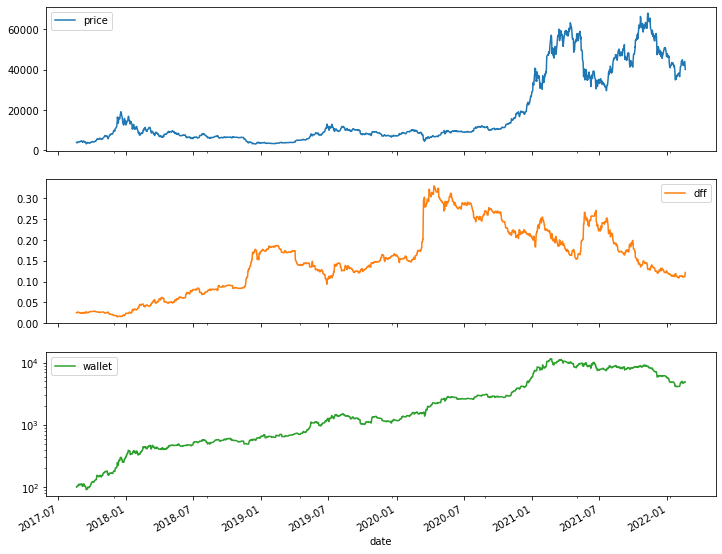

In [13]:
dt['dff'] = dt['wallet']/dt['price']

dt[['price','dff','wallet']].plot(subplots=True, figsize=(12,10))
plt.semilogy()